# <div align = "center"> Naïve Bayes model </div>

# <font color = "red"><div align = "left"> Data importation and processing </font></div>

In [335]:
import pandas as pd
import numpy as np 
import math as mt 
import re
import nltk
from nltk.corpus import stopwords
from nltk.corpus import twitter_samples 
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer # module for tokenizing strings
import matplotlib.pyplot as plt 
import seaborn as sns
import string

In [336]:
training_path = "../tweet-sentiment-extraction/train.csv"
Train_df = pd.read_csv(training_path)

test_path = "../tweet-sentiment-extraction/test.csv"
Test_df = pd.read_csv(test_path)

In [337]:
# dropping rows with missing values

Train_df = Train_df.dropna()

In [338]:
#stopwords represnt a dictionnary (english words)

nltk.download("stopwords")
stopwords_english = stopwords.words('english')
stopwords_punctuation = string.punctuation

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mrabe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [339]:
#Tokenization function 

def tokens(words):
    # instantiate tokenizer class
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
    reduce_len=True)
    # tokenize tweets
    tweet_tokens = tokenizer.tokenize(words)
    return tweet_tokens

# Removing Hashtags and hyperlinks

def cleaning_tweet(tweet):
    tweet2= re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet2 = re.sub(r'https?://[^\s\n\r]+', '', tweet2)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet2 = re.sub(r'#', '', tweet2)
    return tweet2

# Removing stopwords and punctuation

def remove_stopwords_punctuation(tweet_tokens):
    tweets_clean = []
    for word in tweet_tokens: # Go through every word in your tokens list
        if (word not in stopwords_english and # remove stopwords
            word not in string.punctuation): # remove punctuation
            tweets_clean.append(word)
    return tweets_clean

# Keeping just stems for each work

def stemming(tweet_clean_tokenized):
    # Instantiate stemming class
    stemmer = PorterStemmer()
    # Create an empty list to store the stems
    tweets_stem = []
    for word in tweet_clean_tokenized:
        stem_word = stemmer.stem(word) # stemming word
        tweets_stem.append(stem_word) # append to the list
    return tweets_stem

# processing function

def process_tweet(tweet):
    clear_text = cleaning_tweet(tweet)
    tokenized = tokens(clear_text)
    clean_tweet = remove_stopwords_punctuation(tokenized)
    processed_tweet = stemming(clean_tweet)
    return processed_tweet

In [340]:
#Function for encoding sentiment :

def encoding_sentiment(sentiment):
    if sentiment == "negative":
        return -1
    if sentiment == "neutral":
        return 0
    return 1

In [341]:
#Applying this function on the training dataset


Train_df["text_clear"] = Train_df["text"].apply(process_tweet)
Train_df["selected_text_clear"] = Train_df["selected_text"].apply(process_tweet)

In [342]:
import pandas as pd

# Assuming you have a DataFrame df with data and labels
train_size = 0.8

X_train = Train_df.sample(frac=train_size, random_state=105)
X_val = Train_df.drop(X_train.index)

X_train["sentiment"] = X_train["sentiment"].apply(lambda x : encoding_sentiment(x))
X_val["sentiment"] = X_val["sentiment"].apply(lambda x : encoding_sentiment(x))

y_train = X_train["sentiment"]
y_val = X_val["sentiment"]

X_train = X_train.drop(columns = ["textID","selected_text","text","selected_text_clear", "sentiment"])
X_val = X_val.drop(columns = ["textID","selected_text","text","selected_text_clear", "sentiment"])

### <font color = "red"><div align = "left"> Let now build our frequencies dictionnary, so as to build the probabilities table </font></div>

In [343]:
#Building the corpus of our dataset

corpus = []
for list_words in X_train["text_clear"]:
    for word in list_words:
        if word not in corpus:
            corpus.append(word)

In [344]:
# Function that builds the frequency doctionnary for each pair of word and sentiment

def build_freqs(tweets, labels):

    yslist = np.squeeze(labels).tolist()
    # Start with an empty dictionary and populate it by looping over all tweets
    # and over all processed words in each tweet.
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in tweet:
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1
    return freqs

In [345]:
freqs_dict = build_freqs(X_train["text_clear"], y_train)

In [346]:
# This function computes the conditional prbability of each (word, class) and the prior probability

def train_naive_bayes(freqs= freqs_dict, train_x= X_train, train_y= y_train):

    probabilities = dict()
    priors = [0,0,0]


    # calculate V, the number of unique words in the vocabulary for each class 

    vocab = set([tuple(x)[0] for x in freqs.keys()])
    vocab_neu = set(word for word, sentiment in freqs.keys() if sentiment == 0)
    vocab_pos = set(word for word, sentiment in freqs.keys() if sentiment == 1)
    vocab_neg = set(word for word, sentiment in freqs.keys() if sentiment == -1)

    V_neu = len(vocab_neu)
    V_pos = len(vocab_pos)
    V_neg = len(vocab_neg)
    

    # Computing N_pos, N_neg, N_neu

    N_pos, N_neg, N_neu = 0,0,0
    for pair in freqs.keys():

        if pair[1] == 0:
            N_neu +=freqs[pair]
        
        if pair[1] == -1:
            N_neg +=freqs[pair]
        
        else :
            N_pos +=freqs[pair]

    D = len(train_y)

    D_pos = sum([y == 1 for y in train_y])

    D_neg = len([y == -1 for y in train_y])

    D_neu = len([y == 0 for y in train_y])

    priors = [D_neu/D, D_pos/D, D_neg/D]

    for word in vocab:

        freq_pos = freqs.get((word,1),0)
        freq_neg = freqs.get((word,-1),0)
        freq_neu = freqs.get((word,0),0)

        # Laplacian smoothing

        probabilities[(word, 1)] = (freq_pos + 1) / (N_pos + V_pos)
        probabilities[(word, 0)] = (freq_neu + 1) / (N_neu + V_neu)
        probabilities[(word, -1)] = (freq_neg + 1) / (N_neg + V_neg)



    return priors, probabilities

In [347]:
priors, proba_table = train_naive_bayes(freqs_dict, X_train, y_train)

In [348]:
mapping_sentiment = {0:0, 1:1, 2:-1}

In [349]:
import numpy as np

def predict_naive_bayes(processed_tweet, priors, proba_table):

    #Computing the probality conditional for each class proba[sentiment]
    
    probas = [priors[0],priors[1],priors[-1]]

    for word in processed_tweet:

        probas[0] *= proba_table.get((word,0),1)
        probas[1] *= proba_table.get((word,1),1)
        probas[-1] *= proba_table.get((word,-1),1)

    # Sorting the indexes with respect to the value of the list at the the index position
    # Reverse the ordre to have an increasing order

    probas_sorted = np.argsort(np.array(probas))[::-1]

    return mapping_sentiment[probas_sorted[0]]

In [350]:
# Predictions

y_pred_sentiment = []

for tweet in X_val["text_clear"]:
    
    y_pred_sentiment.append(predict_naive_bayes(tweet, priors, proba_table))


In [351]:
# Computing the accuracy

m = len(y_pred_sentiment)

y_val_arr = np.array(y_val)

accuracy = np.sum(np.array(y_pred_sentiment) == y_val_arr)/m

accuracy

0.5016375545851528

In [352]:
# Classification report

from sklearn.metrics import classification_report

report = classification_report(y_val_arr, np.array(y_pred_sentiment))
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

          -1       0.52      0.76      0.61      1538
           0       0.47      0.64      0.54      2241
           1       0.99      0.09      0.16      1717

    accuracy                           0.50      5496
   macro avg       0.66      0.50      0.44      5496
weighted avg       0.64      0.50      0.44      5496



In [353]:
from sklearn.metrics import confusion_matrix

# Create a confusion matrix
conf_matrix = confusion_matrix(y_val_arr, y_pred_sentiment)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1162  375    1]
 [ 798 1442    1]
 [ 282 1282  153]]


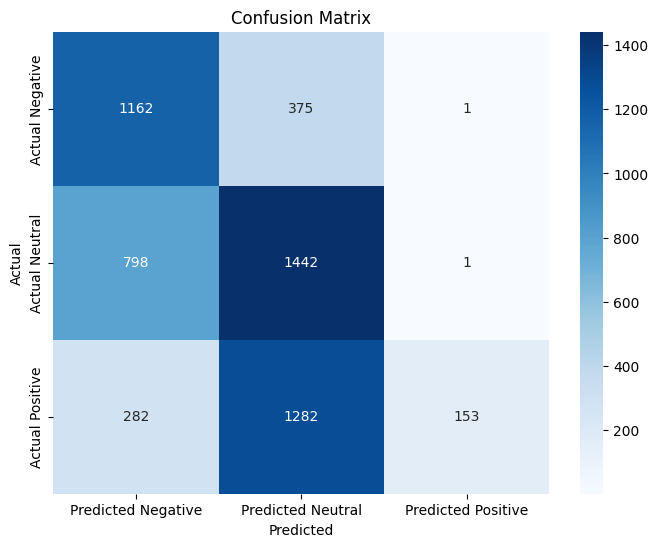

In [354]:
# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Negative", "Predicted Neutral", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Neutral","Actual Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### <font color = red><div align = left> Let test our model one the training set</font></div>

In [355]:
# Predictions

y_pred_sentiment_train = []

for tweet in X_train["text_clear"]:
    
    y_pred_sentiment_train.append(predict_naive_bayes(tweet, priors, proba_table))


In [356]:
# Computing the accuracy

m = len(y_pred_sentiment_train)

y_train_arr = np.array(y_train)

accuracy = np.sum(np.array(y_pred_sentiment_train) == y_train_arr)/m

accuracy

0.6176310043668122

In [357]:
# Classification report

from sklearn.metrics import classification_report

report = classification_report(y_train_arr, np.array(y_pred_sentiment_train))
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

          -1       0.65      0.91      0.76      6243
           0       0.57      0.81      0.67      8876
           1       0.98      0.10      0.19      6865

    accuracy                           0.62     21984
   macro avg       0.74      0.61      0.54     21984
weighted avg       0.72      0.62      0.55     21984



In [358]:
from sklearn.metrics import confusion_matrix

# Create a confusion matrix
conf_matrix_train = confusion_matrix(y_train_arr, y_pred_sentiment_train)

print("Confusion Matrix:")
print(conf_matrix_train)

Confusion Matrix:
[[5708  531    4]
 [1716 7152    8]
 [1302 4845  718]]


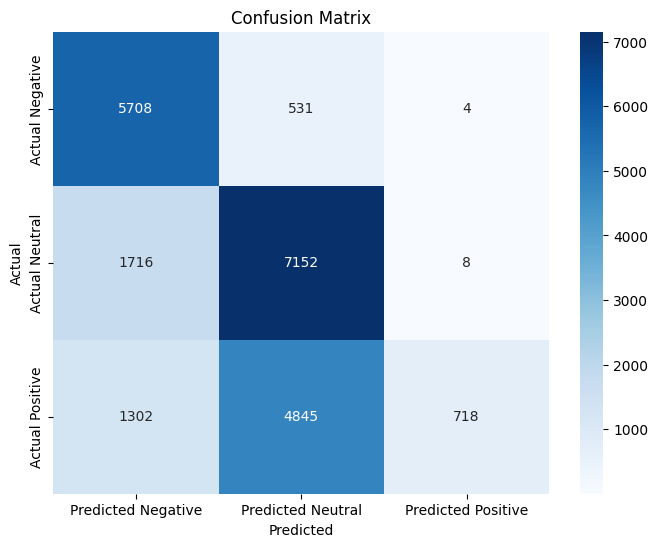

In [360]:
# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Negative", "Predicted Neutral", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Neutral","Actual Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# <div align = center> This good is quite good given its simplicity.</div>
# <div align = center>  But we still have to improve the results since our model doesn't perform well for all classes. </div>
# <div align = center> The next step will be to try probabilistic models. </div>
